# Лабораторная работа №1

Конфигурация нейронной сети:

1. Входной слой содержит `w x h` нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет 28x28).
2. Выходной слой содержит `k` нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – 10 классов).
3. Скрытый слой содержит `s` нейронов (параметр).
4. Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
5. В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
6. В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
7. Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
    - Размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти).
    - Скорость обучения - 0.1.
    - Количество скрытых нейронов `s` - 300.
    - Количество эпох – 20.

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import struct
from array import array
from pathlib import Path
from time import time
%matplotlib inline

Mnist data loader example: https://www.kaggle.com/code/hojjatk/read-mnist-dataset

In [ ]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            # img = img.reshape(28, 28)
            # images[i][:] = img
            images[i] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

MNIST Dataset

https://www.kaggle.com/datasets/hojjatk/mnist-dataset

In [ ]:
data_path = Path("/content/mnist")
training_images_path = data_path / "train-images.idx3-ubyte"
training_labels_path = data_path / "train-labels.idx1-ubyte"
test_images_path = data_path / "t10k-images.idx3-ubyte"
test_labels_path = data_path / "t10k-labels.idx1-ubyte"

In [ ]:
loader = MnistDataloader(training_images_path, training_labels_path, test_images_path, test_labels_path)
(X_train, y_train), (X_test, y_test) = loader.load_data()

In [ ]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image.reshape(28, 28), cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)
        index += 1

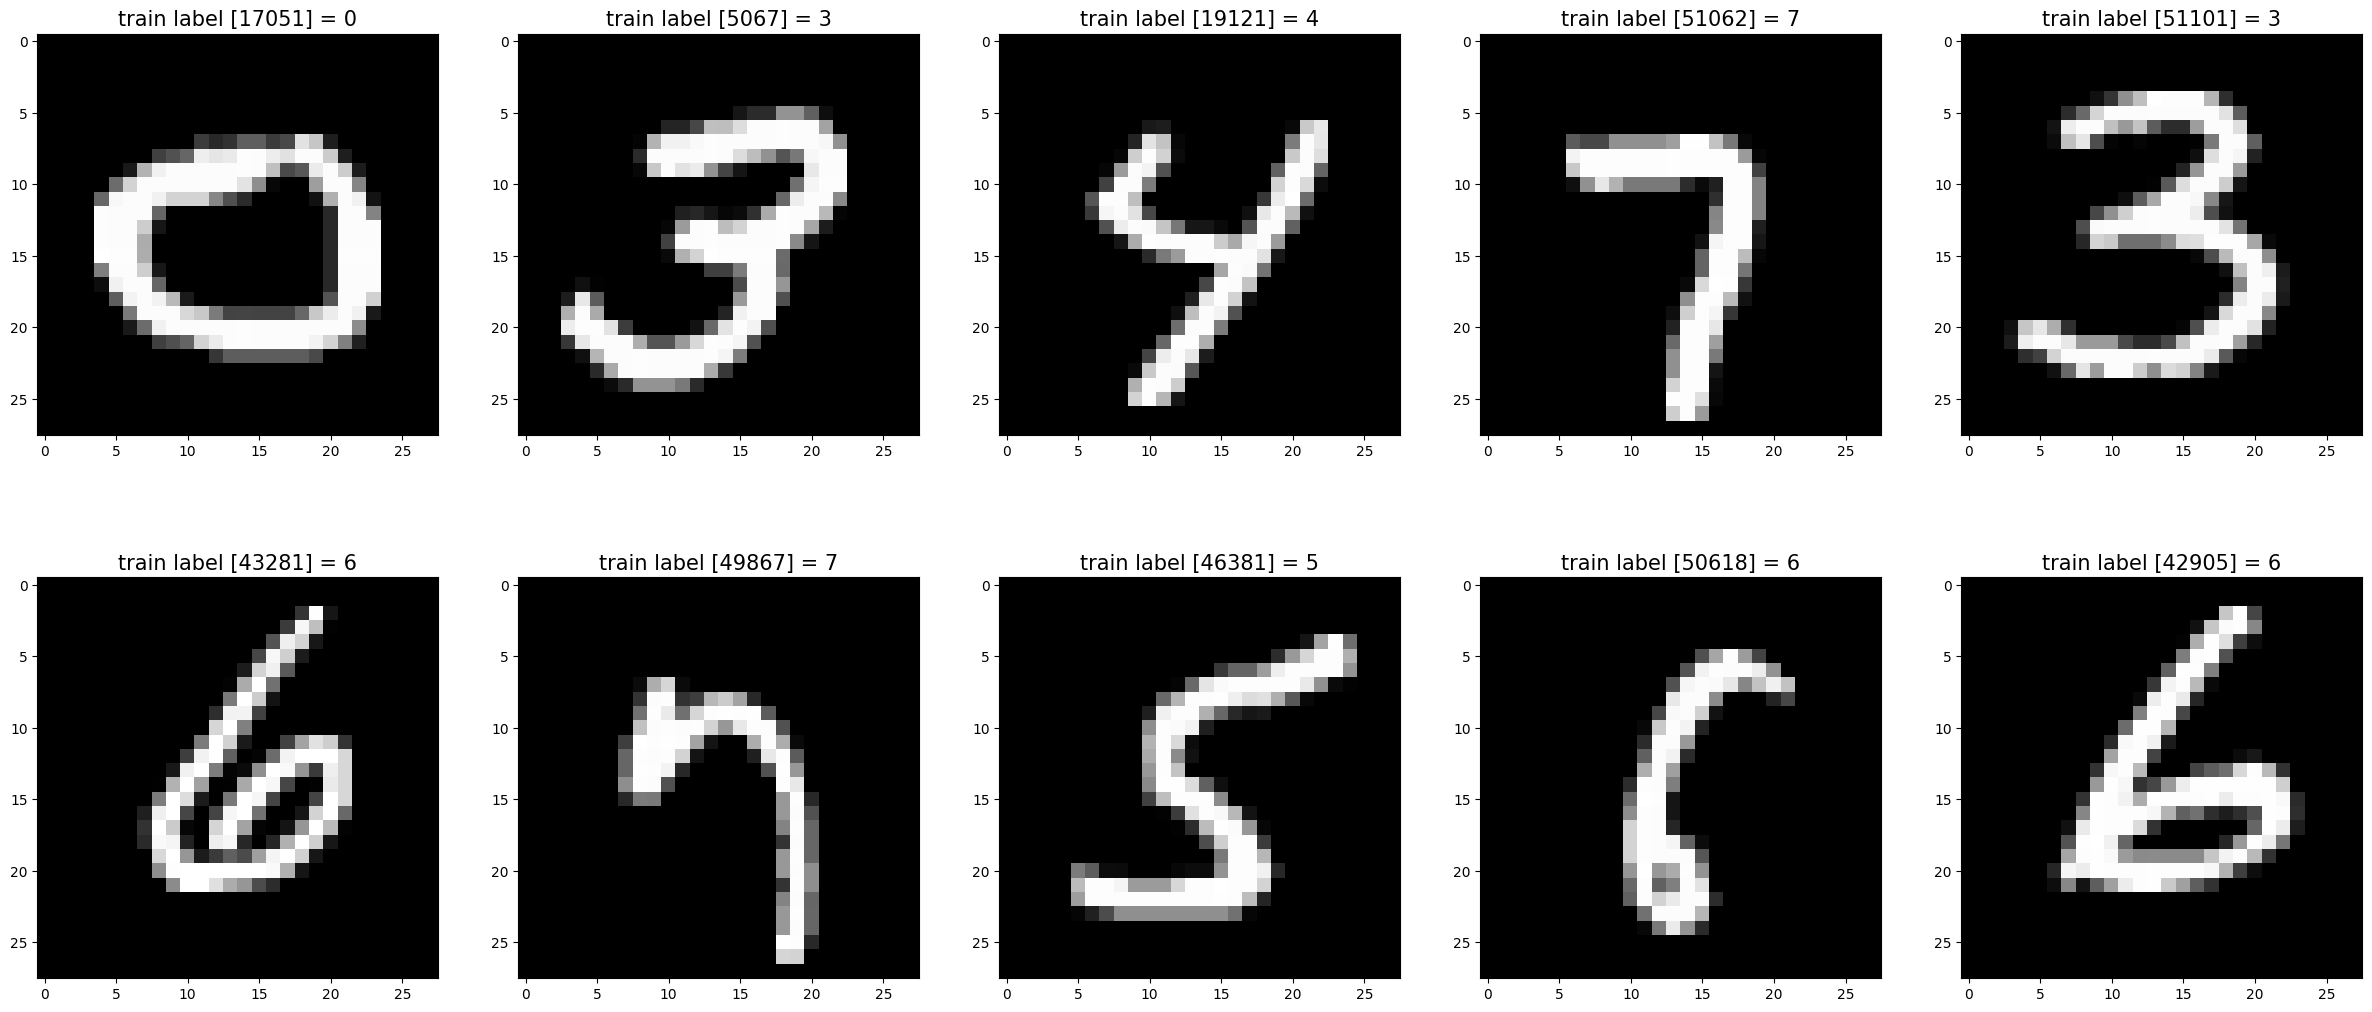

In [ ]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('train label [' + str(r) + '] = ' + str(y_train[r]))

show_images(images_2_show, titles_2_show)

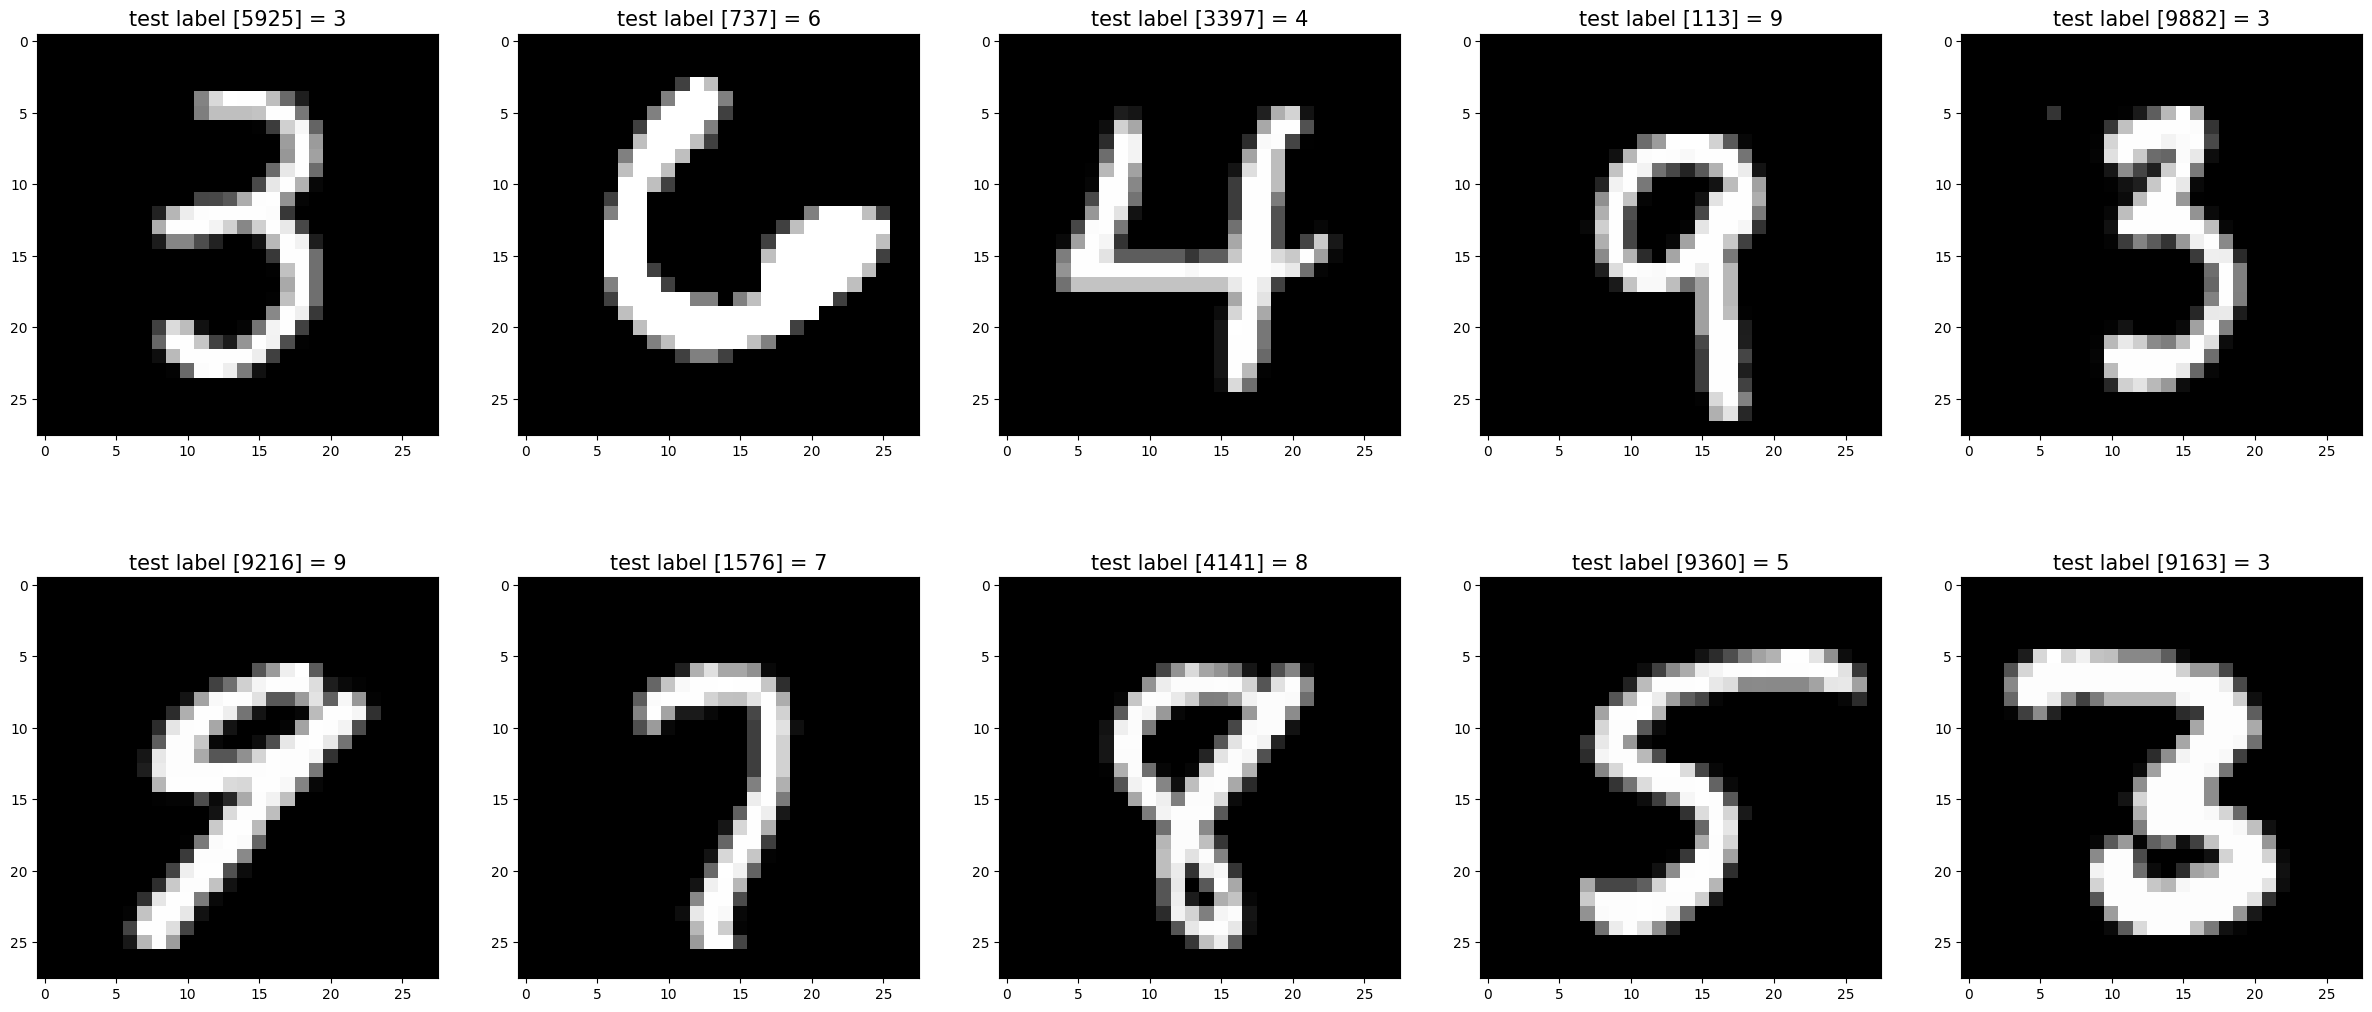

In [ ]:
images_2_show = []
titles_2_show = []

for i in range(0, 10):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append('test label [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [ ]:
def one_hot_encoder(arr):
    return np.eye(10)[arr]

In [ ]:
X_train = np.array(X_train, dtype=np.float64) / 255.0
X_test = np.array(X_test, dtype=np.float64) / 255.0
y_train = one_hot_encoder(y_train)
y_test = one_hot_encoder(y_test)

In [ ]:
print(f"28 * 28 = {28 * 28}")
print(f"X_train dimentions: {X_train.shape}")
print(f"y_train dimentions: {y_train.shape}\n\n")
print(f"X_test dimentions: {X_test.shape}")
print(f"y_test dimentions: {y_test.shape}")



28 * 28 = 784
X_train dimentions: (60000, 784)
y_train dimentions: (60000, 10)


X_test dimentions: (10000, 784)
y_test dimentions: (10000, 10)


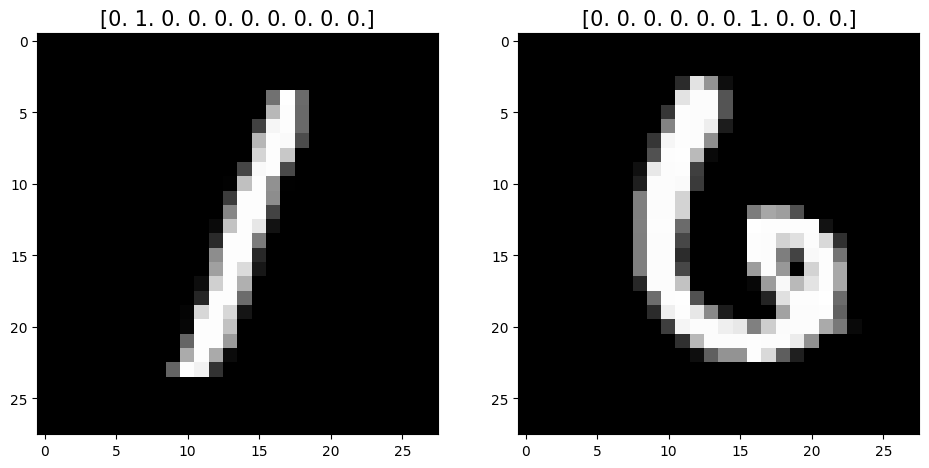

In [ ]:
images_2_show = []
titles_2_show = []

for i in range(0, 2):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append(str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return x > 0

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / exp.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    batch = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / batch

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, output_size, hidden_layer_size):
        # Kaiming Initialization (https://paperswithcode.com/method/he-initialization)
        self.hidden_layer_weights = np.random.random((input_size, hidden_layer_size)) * math.sqrt(2.0 / input_size)
        self.hidden_layer_bias = np.zeros((1, hidden_layer_size))
        self.output_layer_weights = np.random.random((hidden_layer_size, output_size)) * math.sqrt(2.0 / hidden_layer_size)
        self.output_layer_bias = np.zeros((1, output_size))

    def forward(self, input_data, calculate_gradients=False):
        hidden_layer_res = input_data.dot(self.hidden_layer_weights) + self.hidden_layer_bias
        relu_res = relu(hidden_layer_res)
        output_layer_res = relu_res.dot(self.output_layer_weights) + self.output_layer_bias
        softmax_res = softmax(output_layer_res)

        if calculate_gradients:
            self.hidden_layer_res = hidden_layer_res
            self.relu_res = relu_res
            self.output_layer_res = output_layer_res
            self.softmax_res = softmax_res
            return self.softmax_res

        return softmax_res

    def backward(self, input_data, predicted_output, actual_output, learning_rate=0.1):
        batch_size = actual_output.shape[0]

        grad_softmax = predicted_output - actual_output
        grad_output_layer_weights = self.relu_res.T.dot(grad_softmax) / batch_size
        grad_output_layer_bias = np.sum(grad_softmax, axis=0, keepdims=True) / batch_size
        grad_relu = grad_softmax.dot(self.output_layer_weights.T) * relu_derivative(self.hidden_layer_res)
        grad_hidden_layer_weights = input_data.T.dot(grad_relu) / batch_size
        grad_hidden_layer_bias = np.sum(grad_relu, axis=0, keepdims=True) / batch_size

        self.hidden_layer_weights -= learning_rate * grad_hidden_layer_weights
        self.hidden_layer_bias -= learning_rate * grad_hidden_layer_bias
        self.output_layer_weights -= learning_rate * grad_output_layer_weights
        self.output_layer_bias -= learning_rate * grad_output_layer_bias

        self.hidden_layer_res = None
        self.relu_res = None
        self.output_layer_res = None
        self.softmax_res = None

In [ ]:
input_size = 784
hidden_size = 300
output_size = 10
learning_rate = 0.1
batch_size = 64
epochs = 20

model = NeuralNetwork(input_size, output_size, hidden_size)
train_accuracy_prev = 0.0
test_accuracy_prev = 0.0

total_start = time()

for epoch in range(epochs):
    print("_________________")
    print(f"Epoch {epoch + 1}/{epochs}")

    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]

    start_time = time()
    losses = []

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        output = model.forward(X_batch, calculate_gradients=True)
        loss = cross_entropy_loss(y_batch, output)
        losses.append(loss)

        model.backward(X_batch, output, y_batch, learning_rate)

    output = model.forward(X_train)
    train_accuracy = np.mean(np.argmax(output, axis=1) == np.argmax(y_train, axis=1))
    loss_mean = np.mean(losses)

    end_time = time()
    print("Training:")
    print(f" - Duration: {end_time - start_time:.2f} seconds")
    print(f" - Average Loss: {loss_mean:.4f}")
    print(f" - Training Accuracy: {train_accuracy:.4f}")
    print(f" - Δ Training Accuracy: {train_accuracy - train_accuracy_prev:.4f}\n")

    train_accuracy_prev = train_accuracy

    eval_output = model.forward(X_test)
    test_accuracy = np.mean(np.argmax(eval_output, axis=1) == np.argmax(y_test, axis=1))

    print("Test:")
    print(f" - Test Accuracy: {test_accuracy:.4f}")
    print(f" - Δ Test Accuracy: {test_accuracy - test_accuracy_prev:.4f}")

    test_accuracy_prev = test_accuracy

total_end = time()
print(f"Total duration: {total_end - total_start:2f} seconds")

_________________
Epoch 1/20
Training:
 - Duration: 6.25 seconds
 - Average Loss: 0.5937
 - Training Accuracy: 0.9115
 - Δ Training Accuracy: 0.9115

Test:
 - Test Accuracy: 0.9124
 - Δ Test Accuracy: 0.9124
_________________
Epoch 2/20
Training:
 - Duration: 5.82 seconds
 - Average Loss: 0.2531
 - Training Accuracy: 0.9414
 - Δ Training Accuracy: 0.0299

Test:
 - Test Accuracy: 0.9391
 - Δ Test Accuracy: 0.0267
_________________
Epoch 3/20
Training:
 - Duration: 6.96 seconds
 - Average Loss: 0.1910
 - Training Accuracy: 0.9534
 - Δ Training Accuracy: 0.0120

Test:
 - Test Accuracy: 0.9511
 - Δ Test Accuracy: 0.0120
_________________
Epoch 4/20
Training:
 - Duration: 5.35 seconds
 - Average Loss: 0.1495
 - Training Accuracy: 0.9639
 - Δ Training Accuracy: 0.0105

Test:
 - Test Accuracy: 0.9607
 - Δ Test Accuracy: 0.0096
_________________
Epoch 5/20
Training:
 - Duration: 7.64 seconds
 - Average Loss: 0.1226
 - Training Accuracy: 0.9683
 - Δ Training Accuracy: 0.0044

Test:
 - Test Accu